# Logistic Regression Model for NLP Breast Cancer Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn import set_config
set_config(display='diagram')
import joblib
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
data = pd.read_excel('drive/MyDrive/June/Supplementary2_V2_preprocessed.xlsx')
                     #usecols=['ASSOCIATION_CLASS', 'REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem'])
# Overview of columns in dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10045 entries, 0 to 10044
Data columns (total 20 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   DB_ID                                              10045 non-null  object 
 1   DISEASE                                            10042 non-null  object 
 2   DIS_CLASS                                          10045 non-null  object 
 3   GENE                                               10045 non-null  object 
 4   PUBMED.ID                                          10045 non-null  int64  
 5   LACKASSO                                           10045 non-null  object 
 6   TITLE                                              2676 non-null   object 
 7   YEAR                                               10045 non-null  int64  
 8   CONCLUSION                                         8502 non-null   object 
 9   REF_SE

## Split dataset into train and test sets

In [ ]:
# X and Y columns
data[['REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem', 'ASSOCIATION_CLASS']]

,REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem,ASSOCIATION_CLASS
0,no differ pattern lmyc rflp were found breast ...,N
1,cyp1a1 is gene cytochrom p450 famili ha propos...,A
2,howev mutat analysi ecadherin multipl foci car...,A
3,find provid no evid role comt val58met cyp1a12...,N
4,find provid no evid role comt val58met cyp1a12...,N
...,...,...
10040,purpos studi wa determin whether sipa1 c polym...,X
10041,studi sipa1 c polymorph wa detect metastat bre...,X
10042,found sipa1 c polymorph wa significantli assoc...,Y
10043,find indic metastat breast cancer patient sipa...,X


In [ ]:
X = data.drop('ASSOCIATION_CLASS', axis=1)
y = data['ASSOCIATION_CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train)

8036

## Grid search

In [ ]:
# Create pipeline consisting of vectorizer + classifier
pipeline = Pipeline(steps=[("vectorizer", CountVectorizer()),
                           ("classifier", LogisticRegression(random_state=20231015, max_iter=500))])
pipeline

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier',
                 LogisticRegression(max_iter=500, random_state=20231015))])

In [ ]:
# Search space of hyperparameters
param_grid={
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (2,2), (2,3)],
    'classifier__C': [1e-3, 1e-2, 1e-1, 1, 10]
}

In [ ]:
# Stratified K-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# Perform grid search
search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', n_jobs=-1, cv=cv, verbose=1, error_score='raise')
result = search.fit(X_train['REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem'], y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best Score: 0.7966874196170082
Best Hyperparameters: {'classifier__C': 1, 'vectorizer__ngram_range': (1, 3)}


In [ ]:
# Best-performing model with final hyperparameters
best_model = result.best_estimator_
best_model

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('classifier',
                 LogisticRegression(C=1, max_iter=500, random_state=20231015))])

In [ ]:
# Save best model
joblib.dump(best_model, 'drive/MyDrive/June/LR_model.pkl')

['drive/MyDrive/June/LR_model.pkl']

## Performance evaluation

In [ ]:
# Load best model
best_model = joblib.load('drive/MyDrive/June/LR_model.pkl')

In [ ]:
print('Distribution of true labels:')
print('Training set:')
print(y_train.value_counts())
print('Test set:')
print(y_test.value_counts())

Distribution of true labels:
Training set:
X    3915
Y    2017
A    1292
N     812
Name: ASSOCIATION_CLASS, dtype: int64
Test set:
X    985
Y    490
A    328
N    206
Name: ASSOCIATION_CLASS, dtype: int64


### Get predictions and probabilities

In [ ]:
print('Training set:')
# Get the predicted probabilities for each class
y_pred_proba_train = best_model.predict_proba(X_train['REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem'])
print(y_pred_proba_train)
# The class with the highest probability becomes the prediction
y_pred_train = np.argmax(y_pred_proba_train, axis=1)
classes = best_model.classes_
# Mapping of indices (0, 1, 2, 3) to classes (A, N, X, Y)
y_pred_train = np.array([classes[i] for i in y_pred_train])
print(y_pred_train)
print('Test set:')
y_pred_proba_test = best_model.predict_proba(X_test['REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem'])
print(y_pred_proba_test)
y_pred_test = np.argmax(y_pred_proba_test, axis=1)
y_pred_test = np.array([classes[i] for i in y_pred_test])
X_test['prediction'] = y_pred_test
# Obtain maximum predicted probability (i.e. prob of predicted class)
y_pred_max_proba_test = np.max(y_pred_proba_test, axis=1)
X_test['predicted_probability'] = y_pred_max_proba_test
print(y_pred_test)

Training set:
[[4.69897950e-04 8.92164343e-06 9.99297271e-01 2.23909682e-04]
 [7.37336705e-03 9.86280479e-03 9.71044249e-01 1.17195787e-02]
 [3.84519666e-03 6.89387401e-01 6.98437844e-05 3.06697558e-01]
 ...
 [8.42413969e-02 4.46338547e-04 2.23509257e-02 8.92961339e-01]
 [1.02848628e-02 5.86710671e-04 2.22032863e-06 9.89126206e-01]
 [4.09739166e-04 2.44864365e-03 9.91634445e-01 5.50717198e-03]]
['X' 'X' 'N' ... 'Y' 'Y' 'X']
Test set:
[[8.32039518e-04 5.76577552e-04 2.69546159e-04 9.98321837e-01]
 [4.45146219e-01 2.48222900e-03 1.63832250e-01 3.88539302e-01]
 [1.32550937e-02 2.60615911e-03 9.19368711e-01 6.47700361e-02]
 ...
 [2.88957945e-01 4.63798390e-02 2.72795754e-03 6.61934258e-01]
 [3.08788174e-03 8.40764004e-03 1.55727568e-02 9.72931721e-01]
 [4.42141639e-03 8.32130880e-03 2.96415836e-01 6.90841439e-01]]
['Y' 'A' 'X' ... 'Y' 'Y' 'Y']


### Show metrics

In [ ]:
print('Training set:')
display(pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True)).T)
print('\nTest set:')
display(pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).T)

Training set:


,precision,recall,f1-score,support
A,0.999227,1.000000,0.999613,1292.000000
N,1.000000,1.000000,1.000000,812.000000
X,1.000000,0.999745,0.999872,3915.000000
Y,0.999504,0.999504,0.999504,2017.000000
accuracy,0.999751,0.999751,0.999751,0.999751
macro avg,0.999683,0.999812,0.999747,8036.000000
weighted avg,0.999751,0.999751,0.999751,8036.000000



Test set:


,precision,recall,f1-score,support
A,0.840000,0.768293,0.802548,328.000000
N,0.827225,0.766990,0.795970,206.000000
X,0.870690,0.922843,0.896008,985.000000
Y,0.782700,0.757143,0.769710,490.000000
accuracy,0.841215,0.841215,0.841215,0.841215
macro avg,0.830154,0.803817,0.816059,2009.000000
weighted avg,0.839762,0.841215,0.839687,2009.000000


### Confusion matrix

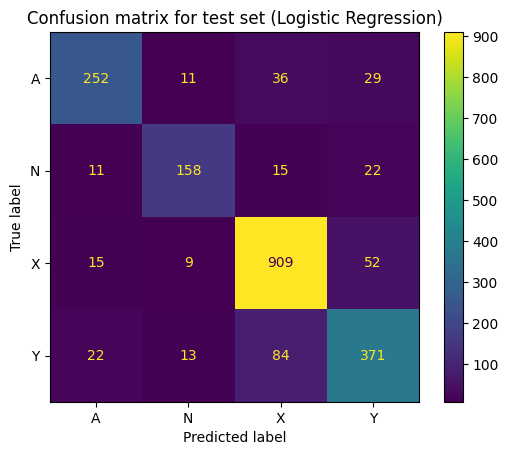

In [ ]:
# For test set
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.title('Confusion matrix for test set (Logistic Regression)')
plt.show()

### ROC curve (One-vs-Rest)

In [ ]:
# binarize the target by one-hot-encoding in a OvR fashion
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(2009, 4)

In [ ]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_proba_test[:, i])
    roc_auc[classes[i]] = auc(fpr[i], tpr[i])

print('ROC AUC score for each class:')
for item in roc_auc.items():
  print(item)

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(len(classes)):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= len(classes)

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

ROC AUC score for each class:
('A', 0.9531964132847752)
('N', 0.9732673160697651)
('X', 0.9547093115482235)
('Y', 0.9272776128226141)
Macro-averaged One-vs-Rest ROC AUC score:
0.95


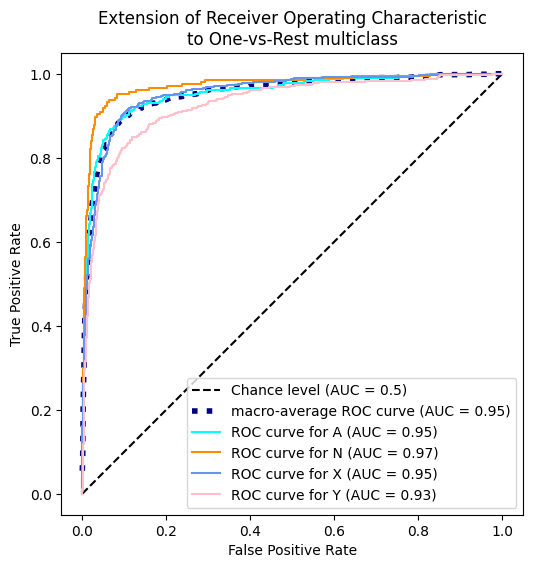

In [ ]:
# Plot ROC curve for all classes as well as macro average
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot([0, 1], [0, 1], label='Chance level (AUC = 0.5)', color='black', linestyle='dashed')

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue", 'pink']
for class_id, color in zip(range(len(classes)), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_proba_test[:, class_id],
        name=f"ROC curve for {classes[class_id]}",
        color=color,
        ax=ax
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

## Hypothesis evaluation

### Question 1: Gene classification

In [ ]:
# Count association classes for every gene
gene_class_counts = data.groupby(['REF_GENE'])['ASSOCIATION_CLASS'].value_counts().unstack()
# Get the primary class without the no-info class since it's the most frequent one
primary_class = gene_class_counts.drop('X', axis=1).idxmax(axis=1)

In [ ]:
pd.set_option('display.max_colwidth', None)
# Number of positive genes in test set
#print(len(set(X_test[y_test == 'Y']['REF_GENE'])), 'positive genes in test set')
# Genes with a primary positive association
positive_genes = gene_class_counts[primary_class == 'Y'].index
# Number of PRIMARY positive instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'Y'].index) & X_test['REF_GENE'].isin(positive_genes)]['REF_GENE']), 'PRIMARY positive instances in test set')
# Correctly predicted positive genes
correct_Y = X_test.loc[y_test[(y_pred_test == 'Y') & (y_test == 'Y')].index]
# PRIMARY positive instances in test set that were correctly predicted
correct_Y_primary = correct_Y[correct_Y['REF_GENE'].isin(positive_genes)]
print(len(correct_Y_primary), 'PRIMARY positive instances in test set that were correctly predicted\n')
print(correct_Y_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_Y_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_Y_primary['WEIGHT']))
correct_Y_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

398 PRIMARY positive instances in test set
296 PRIMARY positive instances in test set that were correctly predicted

BRCA2     17
BRCA1     16
GSTM1     11
FGFR2     11
GSTT1      9
          ..
NME1       1
FAS        1
MDM4       1
NPAS2      1
CLDN10     1
Name: REF_GENE, Length: 148, dtype: int64
Average predicted probability: 0.9019582341056246
Average asssociation weight: 0.6837842413783783


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
6485,"In summary, this meta-analysis suggests that MTHFR C677T polymorphism is associated with increased breast cancer, gastric cancer, and hepatocellular cancer risk in Asians, is associated with increased gastric cancer, multiple myeloma, and NHL risk in Caucasians, is associated with decreased AALL risk in Caucasians, is associated with decreased CALL risk in Asians, is associated with increased breast cancer risk in Asians, is associated with decreased colon cancer risk, and is associated with decreased colorectal cancer risk in male population.",MTHFR,MTHFR,0.999996,0.508333
6486,"In summary, this meta-analysis suggests that MTHFR C677T polymorphism is associated with increased breast cancer, gastric cancer, and hepatocellular cancer risk in Asians, is associated with increased gastric cancer, multiple myeloma, and NHL risk in Caucasians, is associated with decreased AALL risk in Caucasians, is associated with decreased CALL risk in Asians, is associated with increased breast cancer risk in Asians, is associated with decreased colon cancer risk, and is associated with decreased colorectal cancer risk in male population.",CALL,CHL1,0.999995,1.000000
766,"We found that significantly increased risk of breast cancer was associated with variant genotypes in the H2AFX promoter: adjusted odds ratio [OR] = 1.80, 95% confidence interval [CI] = 1.38-2.34 for -1654AG/GG; OR = 1.40, 95% CI = 1.07-1.83 for -1420GA/AA; and OR = 1.65, 95% CI = 1.26-2.16 for -1187TC/CC. Furthermore, the number of variant alleles in the promoter haplotypes was associated with increased risks of breast cancer in a dose-response manner (OR = 6.08, 95% CI = 3.25-11.38; OR = 6.83, 95% CI = 3.83-12.18; and OR = 23.61, 95% CI = 3.95-140.99 for one, two, and three variant alleles, respectively) (P (trend) \ < 0.0001).",H2AFX,H2AFX,0.999993,0.500000
4832,"The ERCC1 rs11615 variant A/A genotype was associated with increased breast cancer risk in codominant, dominant, and recessive models, and XPF rs6498486 variant C/C genotype carriers have a significantly increased breast cancer risk in codominant, dominant, and recessive models.",XPF,ERCC4,0.999921,0.411765
5400,"Eight of the 16 genes evaluated were associated with breast cancer risk (IL1A, IL1B, IL1RN, IL2, IL2RA, IL4, IL6 and IL10); four genes were associated with breast cancer risk among women with low NA ancestry (IL1B, IL6, IL6R and IL10), two were associated with breast cancer risk among women with high NA ancestry (IL2 and IL2RA) and four genes were associated with premenopausal breast cancer risk (IL1A, IL1B, IL2 and IL3).",IL6,IL6,0.999862,0.481481
...,...,...,...,...,...
908,"Our findings suggest TP53 PIN3 Ins16bp polymorphism as a real risk modifier in breast cancer disease, either in sporadic and familial breast cancer.",TP53,TP53,0.532708,0.512821
8289,"Patients with CHEK2 mutations are significantly more likely to have family histories of cancer, and to develop lymph node-positive and/or PR-positive breast cancers.",CHEK2,CHEK2,0.530634,0.551020
1923,This meta-analysis suggests that FGFR2 is likely an important genetic marker contributing to susceptibility of breast cancer.,FGFR2,FGFR2,0.482267,0.794118
474,Our results suggest that the GNAS1 T393C SNP is a novel genetic host factor for disease progression in patients with invasive breast carcinoma.,GNAS1,GNAS,0.375045,1.000000


In [ ]:
incorrect_Y = X_test.loc[y_test[(y_pred_test != 'Y') & (y_test == 'Y')].index]
# PRIMARY positive instances in test set that were incorrectly predicted
incorrect_Y_primary = incorrect_Y[incorrect_Y['REF_GENE'].isin(positive_genes)]
print(len(incorrect_Y_primary), 'PRIMARY positive instances in test set that were incorrectly predicted\n')
print(incorrect_Y_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_Y_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_Y_primary['WEIGHT']))
incorrect_Y_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

102 PRIMARY positive instances in test set that were incorrectly predicted

BRCA1                    13
BRCA2                    11
TP53                      7
MTHFR                     4
VDR                       3
FGFR2                     3
ER                        2
p53                       2
FANCM                     2
ATM                       2
HER-2                     2
GSTT1                     2
ESR1                      2
HLADRB1* 07-DQB1*02       2
GK2                       1
STAT3                     1
TCF7L2                    1
STK15                     1
UGT2B17                   1
FGF1                      1
TNRC9                     1
HER2                      1
GADD45A                   1
progesterone receptor     1
ODC                       1
RCCD1                     1
HDC                       1
FA                        1
VEGF-A                    1
IL6                       1
KEAP1                     1
CHEK2                     1
ANKLE1                    1


,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
1432,"Twenty-eight polymorphisms in eight genes of phase I (CYP1A1, CYP1A2, CYP1B1, CYP2C9, CYP2C19, CYP3A4, CYP3A5, CYP3A7) and nine genes of phase II enzymes (COMT, GSTM1, GSTM3, GSTP1, GSTT1, SULT1A1, UGT1A1, UGT1A6, UGT2B7) were genotyped... The finding regarding GSTT1 was still statistically significant after corrections for multiple comparisons. Postmenopausal breast cancer risk associated with hormone therapy may be modified by genetically determined variations in phase I and II enzymes involved in steroid hormone metabolism.",GSTT1,GSTT1,A,0.998761,0.672131
3721,The results of our investigation showed that BRCA1 mutation carriers were more likely to have ERalpha-negative breast cancer than those in the control group.,BRCA1,BRCA1,X,0.996960,0.484536
9171,"By reviewing the relevant literatures and summarizing the potential effect of dietary folate intake on MTHFR genes polymorphism and breast cancer risk, we conclude that MTHFR C677T gene polymorphism is associated with breast cancer risk among Asian, but not Caucasians, and the MTHFR A1298C gene polymorphism is not a susceptibility factor of breast cancers.",MTHFR,MTHFR,N,0.996377,0.508333
8078,"Association of FokI (rs2228570) and BsmI (rs1544410) single nucleotide polymorphisms (SNPs) in VDR gene with the risk of breast cancer have been investigated in several studies, however, the published data are still inconsistent.",VDR,VDR,X,0.994045,0.362069
9828,Our findings show a suggestively stronger association between FGFR2 rs2981582 and ER-positive breast cancer risk and suggest a greater association of FGF1 rs250108 and RBFOX2 rs2051579 with ER-negative compared to ER-positive breast cancer.,FGF1,FGF1,X,0.988029,1.000000
...,...,...,...,...,...,...
7871,"While genome-wide association studies (GWAS) have implicated RCCD1 and ANKLE1 in breast cancer risk, they have not identified the remaining three genes.",RCCD1,RCCD1,X,0.473781,1.000000
7868,"While genome-wide association studies (GWAS) have implicated RCCD1 and ANKLE1 in breast cancer risk, they have not identified the remaining three genes.",ANKLE1,ANKLE1,X,0.473781,1.000000
47,This study provides little evidence that variation in Val-9Ala polymorphism of MnSOD alone or through substantial interaction with key exposures believed to be pro- or anti-oxidant properties influences breast cancer risk.,MnSOD,SOD2,X,0.454972,0.235294
1616,"In conclusion, although germline mutations of GADD45A is not common in familial breast cancer patients, polymorphisms/haplotypes in GADD45A contribute to breast cancer risk, at least to sporadic breast cancer.",GADD45A,GADD45A,N,0.422758,1.000000


In [ ]:
# Number of negative genes in test set
#print(len(set(X_test[y_test == 'N']['REF_GENE'])), 'negative genes in test set')
# Genes with a primary negative association
negative_genes = gene_class_counts[primary_class == 'N'].index
# Number of PRIMARY negative instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'N'].index) & X_test['REF_GENE'].isin(negative_genes)]['REF_GENE']), 'PRIMARY negative instances in test set')
# Correctly predicted negative genes
correct_N = X_test.loc[y_test[(y_pred_test == 'N') & (y_test == 'N')].index]
# PRIMARY negative instances in test set that were correctly predicted
correct_N_primary = correct_N[correct_N['REF_GENE'].isin(negative_genes)]
print(len(correct_N_primary), 'PRIMARY negative instances in test set that were correctly predicted\n')
print(correct_N_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_N_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_N_primary['WEIGHT']))
correct_N_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

79 PRIMARY negative instances in test set
63 PRIMARY negative instances in test set that were correctly predicted

ITGB3                                       2
TLR                                         2
MTRR                                        2
TGFBR1*6A                                   2
LEP                                         2
SSTR1-SSTR5                                 2
GH1                                         2
BID                                         1
CRAC1                                       1
RNF146                                      1
GSTO1                                       1
p53--G13964C                                1
SOD2                                        1
ABCB11                                      1
IL-6 -174                                   1
GEN1                                        1
ITGAv                                       1
POT1                                        1
RAD51L1                                     1
KLLN       

,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
35,"We genotyped 22 common single nucleotide polymorphisms in 10 genes involved in GH production and action (GHRH, GHRHR, SST, SSTR1-SSTR5, POU1F1, and GH1), and in parallel, we measured serum levels of IGF-I and IGFBP-3, its major binding protein, in samples of cases and controls... Our conclusion is that common genetic variation in the GH synthesis pathway, as measured by single nucleotide polymorphisms selected in the present study, is not a major determinant of IGF-I and IGFBP-3 circulating levels, and it does not play a major role in altering breast cancer risk.",GH1,GH1,0.999891,0.500000
33,"We genotyped 22 common single nucleotide polymorphisms in 10 genes involved in GH production and action (GHRH, GHRHR, SST, SSTR1-SSTR5, POU1F1, and GH1), and in parallel, we measured serum levels of IGF-I and IGFBP-3, its major binding protein, in samples of cases and controls... Our conclusion is that common genetic variation in the GH synthesis pathway, as measured by single nucleotide polymorphisms selected in the present study, is not a major determinant of IGF-I and IGFBP-3 circulating levels, and it does not play a major role in altering breast cancer risk.",GHRHR,GHRHR,0.999851,1.000000
36,"We genotyped 22 common single nucleotide polymorphisms in 10 genes involved in GH production and action (GHRH, GHRHR, SST, SSTR1-SSTR5, POU1F1, and GH1), and in parallel, we measured serum levels of IGF-I and IGFBP-3, its major binding protein, in samples of cases and controls... Our conclusion is that common genetic variation in the GH synthesis pathway, as measured by single nucleotide polymorphisms selected in the present study, is not a major determinant of IGF-I and IGFBP-3 circulating levels, and it does not play a major role in altering breast cancer risk.",SSTR1-SSTR5,SSTR5,0.999846,1.000000
39,"We genotyped 22 common single nucleotide polymorphisms in 10 genes involved in GH production and action (GHRH, GHRHR, SST, SSTR1-SSTR5, POU1F1, and GH1), and in parallel, we measured serum levels of IGF-I and IGFBP-3, its major binding protein, in samples of cases and controls... Our conclusion is that common genetic variation in the GH synthesis pathway, as measured by single nucleotide polymorphisms selected in the present study, is not a major determinant of IGF-I and IGFBP-3 circulating levels, and it does not play a major role in altering breast cancer risk.",SSTR1-SSTR5,SST,0.999846,0.500000
1254,"There were no statistically significant interactions with NAT2 genotype. Results do not support an important association of HCAs with breast cancer risk, although potential biases in case-control studies should be considered.",NAT2,NAT2,0.999482,0.370370
...,...,...,...,...,...
487,"The results revealed that the ITGB3_Leu33Pro polymorphism was associated with a 2.5-fold increased risk of ovarian cancer, whereas no association with breast cancer risk was found.",ITGB3,ITGB3,0.605384,0.666667
611,"No statistically significant associations were observed for polymorphisms in PPARG, PON2, LPL, or TNF and breast cancer risk or for interactions between the polymorphisms and BMI and breast cancer risk... The findings suggest that specific polymorphisms in the PON1 and LEPR genes may play a role in progression of BBD to breast cancer among post-menopausal Caucasian women.",PPARG,PPARG,0.599831,0.400000
2254,"Although the CCND1 G870A polymorphism has been reported as a genetic risk factor for some tumour types, it does not appear to be linked to the risk of breast and colorectal cancers.",CCND1 G870A,CCND1,0.527514,0.214286
1672,"A cohort of 1,665 adult, female mutation carriers, including 1,122 BRCA1 carriers (433 cases) and 543 BRCA2 carriers (238 cases) were genotyped for SNPs in IGF1, IGF1 receptor (IGF1R), IGF1 binding protein (IGFBP1, IGFBP2, IGFBP5), and IGF receptor substrate 1 (IRS1)... Among BRCA1 carriers, significant associations were found between risk of breast cancer and LD blo

In [ ]:
incorrect_N = X_test.loc[y_test[(y_pred_test != 'N') & (y_test == 'N')].index]
# PRIMARY negative instances in test set that were incorrectly predicted
incorrect_N_primary = incorrect_N[incorrect_N['REF_GENE'].isin(negative_genes)]
print(len(incorrect_N_primary), 'PRIMARY negative instances in test set that were incorrectly predicted\n')
print(incorrect_N_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_N_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_N_primary['WEIGHT']))
incorrect_N_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

16 PRIMARY negative instances in test set that were incorrectly predicted

GNB3 825C               1
IL-18                   1
GSTO1                   1
MMP3 5A/6A              1
JAK2                    1
HIF-1                   1
SHMT1                   1
L-myc                   1
BRIP1                   1
Li-Fraumeni syndrome    1
CYP17 MspA1             1
IGHMBP2                 1
APEX                    1
RAD51L1                 1
CYP1A2                  1
ATP1B2                  1
Name: REF_GENE, dtype: int64
Average predicted probability: 0.6989573575408063
Average asssociation weight: 0.54387427925


,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
5298,"Consistent with their breast cancer associations, the C-allele of rs3817198 in LSP1 was positively associated with both adjusted dense area (P = 0.00005) and adjusted percent density (P = 0.001), whereas the A-allele of rs10483813 in RAD51L1 was inversely associated with adjusted percent density (P = 0.003), but not with adjusted dense area (P = 0.07).",RAD51L1,RAD51B,Y,0.972672,0.250000
5885,This meta-analysis demonstrates that GSTO2 polymorphism may significantly increase cancer risk in Caucasian population and is associated with elevated risk of breast cancer; while GSTO1 polymorphism is not associated with cancer risk.,GSTO1,GSTO1,A,0.949722,0.666667
872,Our results suggest that CYP17 MspA1 polymorphism may be at best a weak modifier of breast cancer risk but is not a significant independent risk factor.,CYP17 MspA1,CYP17A1,A,0.852879,0.245283
8611,"Our results indicated a boardline connection between HIF-1 rs11549467 and BC risk (AG compared with GG: OR = 1.61, 95% CI = 1.05-2.49, P=0.03; AG + AA compared with GG: OR = 1.64, 95% CI = 1.08-2.51, P=0.02; AG compared with GG + AA: OR = 1.61, 95% CI = 1.04-2.48, P=0.03; OR = 1.64, 95% CI = 1.09-2.45, P=0.02), while HIF-2 rs17039192 had no influence on breast cancer.",HIF-1,SETD2,Y,0.832552,1.000000
2375,The MMP3 5A/6A promoter polymorphism does not appear to influence breast cancer susceptibility but may be linked to a higher risk for metastasizing among breast cancer patients.,MMP3 5A/6A,MMP3,A,0.832472,0.285714
3307,"However, we observed no effect for breast cancer, a common Li-Fraumeni syndrome tumor (OR = 1.06, P = 0.57, 95% confidence interval 0.88-1.27).",Li-Fraumeni syndrome,TP53,X,0.821166,0.166667
2348,"No associations with breast cancer were observed for: APEX Q51H; XRCC1 R280H; IGFPB3 -202A>C; TGFss1 L10P, P25R, and T263I; BRCA2 N289H and T1915M; BRIP1 -64A>C; and ZNF350 (or ZBRK1) 1845C>T, L66P, R501S, and S472P... Some variants in genes within the base-excision repair pathway (XRCC1) and BRCA1 interacting proteins (BRIP1) may play a role as low penetrance breast cancer risk alleles. Previous association studies of breast cancer and BRCA2 N372H and functional observations for APEX D148E ran counter to our findings of decreased risks.",APEX,APEX1,A,0.783324,0.375000
0,No differences in the patterns of L-myc RFLP were found between breast cancer patients and healthy individuals.,L-myc,MYCL,X,0.782613,1.000000
713,"In this study, we investigated whether genetic variation in the JAK2 gene and the STAT gene region (STAT3, STAT5A and STAT5B) is associated with breast cancer (BC) risk... Haplotypes in the JAK2 gene were not associated with the risk of BC.",JAK2,JAK2,A,0.706975,0.500000
2301,"We conclude that the GNB3 825C>T polymorphism does not appear to be associated with breast cancer risk, but may influence development of metastasis in low-grade tumors.",GNB3 825C,GNB3,A,0.614475,0.750000


In [ ]:
# Genes with a primary ambiguous association
ambiguous_genes = gene_class_counts[primary_class == 'A'].index
# Number of PRIMARY ambiguous instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'A'].index) & X_test['REF_GENE'].isin(ambiguous_genes)]['REF_GENE']), 'PRIMARY ambiguous instances in test set')
# Correctly predicted ambiguous genes
correct_A = X_test.loc[y_test[(y_pred_test == 'A') & (y_test == 'A')].index]
# PRIMARY ambiguous instances in test set that were correctly predicted
correct_A_primary = correct_A[correct_A['REF_GENE'].isin(ambiguous_genes)]
print(len(correct_A_primary), 'PRIMARY ambiguous instances in test set that were correctly predicted\n')
print(correct_A_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_A_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_A_primary['WEIGHT']))
correct_A_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

202 PRIMARY ambiguous instances in test set
156 PRIMARY ambiguous instances in test set that were correctly predicted

BRCA1/2      7
CYP1A1       5
XPD          4
XRCC1        4
AR           4
            ..
GLO1         1
PI3K         1
USP1         1
CDKN1B       1
CYP1A2*1F    1
Name: REF_GENE, Length: 113, dtype: int64
Average predicted probability: 0.9008027637170087
Average asssociation weight: 0.568192393448718


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
1197,"In the present work we determined the level of basal (total endogenous) and endogenous oxidative DNA damage as well as polymorphism of the DNA repair genes: RAD51 (135 G/C), XRCC3 (Thr241Met), OGG1 (Ser326Cys) and XPD (Lys751Gln) in peripheral blood lymphocytes of 41 breast cancer patients and 48 healthy individuals... Our results suggest that the polymorphism of the RAD51, OGG1 and XPD genes may be linked with breast cancer by the modulation of the cellular response to oxidative stress and these polymorphisms may be considered as markers in breast cancer along with the genetic or/and environmental indicators of oxidative stress.",XPD,ERCC2,0.999921,0.558140
543,"The distribution of the PAI-1 4G/5G genotypes was significantly different between the two groups (p<0.05)... We suggest that this polymorphism may contribute to an inherited predisposition to the development of breast cancer, however further studies with larger series from diverse ethnic populations are needed to confirm our results.",PAI-1,SERPINE1,0.999846,1.000000
1883,"Although larger studies are needed to validate the study results, our data suggest that amino acid substitution variants of XRCC1 and XRCC3 genes may contribute to breast cancer susceptibility.",XRCC3,XRCC3,0.999614,0.421053
210,"the results from our study suggest that the AhR Lys554Arg polymorphism may be a genetic susceptibility factor for breast cancer, whereas CYP1A2*1F, which is a potentially functional single nucleotide polymorphism, may not be related to breast cancer risk.",AhR,AHR,0.999467,0.400000
1441,"Twenty-eight polymorphisms in eight genes of phase I (CYP1A1, CYP1A2, CYP1B1, CYP2C9, CYP2C19, CYP3A4, CYP3A5, CYP3A7) and nine genes of phase II enzymes (COMT, GSTM1, GSTM3, GSTP1, GSTT1, SULT1A1, UGT1A1, UGT1A6, UGT2B7) were genotyped... The finding regarding GSTT1 was still statistically significant after corrections for multiple comparisons. Postmenopausal breast cancer risk associated with hormone therapy may be modified by genetically determined variations in phase I and II enzymes involved in steroid hormone metabolism.",CYP1B1,CYP1B1,0.999072,0.352941
...,...,...,...,...,...
2020,We analysed the allelic frequencies at the polymorphic site C3435T in a group of patients with locally advanced breast cancer treated by preoperative chemotherapy to evaluate its predictive value... Statistical analysis revealed a significant correlation (p=0.029) between clinical complete response to preoperative chemotherapy and the T/T genotype. MDR-1 polymorphism C3435T in exon 26 may co-determine resistance to chemotherapy and provide useful information to individualize therapy.,MDR-1,ABCB1,0.510554,0.517241
828,These data suggest that XPCs have neither independent effects nor interactions with cigarette smoking and PAH-DNA adducts for breast cancer risk. Further studies with multiple genetic polymorphisms in NER pathway are warranted.,XPCs,XPC,0.509911,0.538462
3396,"To conclude, the current study provides substantial evidence for a cross talk between one-carbon metabolism and COMT catalysis that might influence oxidative DNA damage and breast cancer risk.",COMT,COMT,0.507496,0.397059
5549,We conclude that Fas and FasL polymorphisms can affect breast cancer risk and that Fas polymorphisms are likely to affect breast cancer risk by regulating the soluble Fas concentration.,FasL,FASLG,0.499457,0.384615


In [ ]:
incorrect_A = X_test.loc[y_test[(y_pred_test != 'A') & (y_test == 'A')].index]
# PRIMARY ambiguous instances in test set that were incorrectly predicted
incorrect_A_primary = incorrect_A[incorrect_A['REF_GENE'].isin(ambiguous_genes)]
print(len(incorrect_A_primary), 'PRIMARY ambiguous instances in test set that were incorrectly predicted\n')
print(incorrect_A_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_A_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_A_primary['WEIGHT']))
incorrect_A_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

46 PRIMARY ambiguous instances in test set that were incorrectly predicted

RAD51                                4
XPD                                  2
MSH6                                 2
KRAS                                 2
AR                                   2
BRCA1/BRCA2                          2
CYP1A1                               2
BRCA1/2                              2
ADRB2                                1
alcohol dehydrogenase II             1
COMT                                 1
SULT1A                               1
EPH                                  1
PGC                                  1
PHB                                  1
calcium-sensing receptor             1
ICAM1                                1
MDR1                                 1
CYP1A1*2C                            1
HSD17beta1                           1
CHEK1                                1
DHFR                                 1
AKT1                                 1
Cytochrome P450 1B1        

,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
960,We evaluated the presence of single nucleotide polymorphism (SNP) C3435T of the MDR-1 gene and its correlation with the response to primary chemotherapy using the RECIST criteria. Forty-one Brazilian women with stages II and III breast cancer using the PCR-RFLP analysis were evaluated.,MDR-1,ABCB1,X,0.997227,0.517241
4476,"We aimed to evaluate whether the hormone receptor expression, HER2 and MYC genes and their protein status, and KRAS codon 12 mutations may be prognostic or predictive biomarkers of breast cancer.",KRAS,KRAS,X,0.994623,0.444444
4635,This study analyzed the occurrences of polymorphism (SNP) in the MDR1 gene in breast cancer patients and determined a possible association with chemotherapy.,MDR1,ABCB1,X,0.991555,0.517241
465,"The role of allele variants 677T and 1298C (MTHFR gene) and 2756G (MS gene) has been investigated as potentially modifying factors of BRCA gene penetrance, evaluated as age at first diagnosis of cancer, in 484 BRCA1/BRCA2 carriers and in 108 sporadic breast cancer cases as a control group... The presence of 677T allele confers an increased risk of breast cancer in BRCA1 carriers (P = 0.007) and the presence of 1298C allele confers an increased risk of breast cancer in sporadic cases (P = 0.015).",BRCA1/BRCA2,BRCA1,Y,0.990340,0.414948
1626,"MPO can be inhibited and/or upregulated by commonly used drugs; thus, our findings merit further investigation for optimization of therapeutics for breast cancer.",MPO,MPO,X,0.981876,0.500000
1175,Associations between HSD17B1 genotypes and risk for ER- breast cancer were inconsistent across studies and should be studied further.,HSD17B1,HSD17B1,X,0.980254,0.500000
376,"We found no association with the MC1R variants and breast cancer risk. In conclusion, the results of this population-based study show herein that MC1R variants are associated with increased melanoma risk in the Polish population. The risk of disease seems to be increased additively for patients harbouring also the CDKN2A common variant A148T.",CDKN2A,CDKN2A,N,0.976400,0.500000
1087,"We sought to determine whether two common functional polymorphisms in Cytochrome P450 1B1, V432L (m1), and A453S (m2) are related to breast cancer risk... The results presented do not support a strong association between m1 and m2 and the risk of breast cancer.",Cytochrome P450 1B1,CYP1B1,N,0.969428,0.352941
1180,"In our study, we investigated whether polymorphisms of the HIF-1alpha gene may account for the expression patterns of HIF-1alpha protein and impact of clinical progression in breast cancer.",HIF-1alpha,HIF1A,X,0.954835,0.400000
1224,"Variant genotypes XRCC1 Arg/Gln or Gln/Gln and XPD Lys/Gln or Gln/Gln increased both familial and sporadic breast cancer susceptibility... However, when the intra group risk was compared, the risk due to the XPD polymorphic genotypes Lys/Gln or Gln/Gln was significantly lower among familial breast cancer patients compared to sporadic breast cancer patients [OR = 0.61; 95%CI = 0.39-0.94; p value = 0.024) whereas the risk implied by XRCC1 variant genotype was not significantly different between the familial and nonfamilial groups of breast cancer patients [OR = 0.97; 95%CI = 0.63-1.49; p value = 0.882].",XPD,ERCC2,Y,0.947596,0.558140


In [ ]:
# Genes with a primary noinfo association
noinfo_genes = gene_class_counts[primary_class.isna()].index
# Number of PRIMARY noinfo instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'X'].index) & X_test['REF_GENE'].isin(noinfo_genes)]['REF_GENE']), 'PRIMARY no-info instances in test set')
# Correctly predicted noinfo genes
correct_X = X_test.loc[y_test[(y_pred_test == 'X') & (y_test == 'X')].index]
# PRIMARY noinfo instances in test set that were correctly predicted
correct_X_primary = correct_X[correct_X['REF_GENE'].isin(noinfo_genes)]
print(len(correct_X_primary), 'PRIMARY no-info instances in test set that were correctly predicted\n')
print(correct_X_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_X_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_X_primary['WEIGHT']))
correct_X_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

128 PRIMARY no-info instances in test set
118 PRIMARY no-info instances in test set that were correctly predicted

CPM                      3
CPB2                     3
LE                       2
ATP6                     2
MRP1                     2
                        ..
C6orf48                  1
JAK1                     1
MAF                      1
CSMD1                    1
bile salt export pump    1
Name: REF_GENE, Length: 108, dtype: int64
Average predicted probability: 0.9379608586533644
Average asssociation weight: 0.0


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
7163,"The ATAD5 coding and adjacent splice site regions were analyzed by targeted next-generation sequencing of DNA samples from 273 cancer patients, including 114 patients with triple-negative breast cancer and 159 patients with serous epithelial ovarian cancer, and from 276 healthy females.",ATAD5,X,0.999892,0.0
8772,The aim of this study was to evaluate the prognostic potential of urokinase-type plasminogen activator (uPA) and plasminogen activator inhibitor type 1 (PAI-1) tumor tissue levels and examine the association between these biomarkers and classical prognostic factors in early node-negative luminal breast cancer patients.,plasminogen,X,0.999760,0.0
6901,"In this study, we examined 114 paired samples (tumor and normal tissues) from breast cancer patients to study the genotype distribution and somatic mutation of the SNP in MIR 196A2 (rs11614913 C-T).",MIR,X,0.999720,0.0
4411,"In the present study, MDR1 and MRP1 gene expression were investigated by real time reverse transcription polymerase chain reaction (RT-PCR) assay in 54 breast cancer tumors and in corresponding adjacent normal tissues before neoadjuvant chemotherapy.",MRP1,X,0.999707,0.0
6377,"The relationship between tumor messenger RNA (mRNA) expression and plasma levels of TF and TFPI (������������ and ���������������), tagging single nucleotide polymorphisms (tagSNPs) in F3 (TF) (n=6) and TFPI (n=18), and clinicopathological characteristics and molecular tumor subtypes were explored in 152 treatment naive breast cancer patients.",TF,X,0.999555,0.0
...,...,...,...,...,...
7930,These results suggest a mechanism for genetic variation in E1C plasma concentrations as well as possible SNP biomarkers to identify ER+ breast cancer patients for whom STS inhibitors might be of clinical value.,STS,X,0.635713,0.0
9764,"In addition, both chr6_31911109 at C6orf48 and chr6_31975605 at ZBTB12, another two of the seven SNPs, show relevance with ER-positive breast cancer.",C6orf48,X,0.606076,0.0
3288,"Because previous in vitro and ex vivo experiments have consistently suggested that LIN28 could promote cellular transformation, we then systematically evaluated the relationship between rs3811463 as well as other common LIN28 SNPs and the risk of breast cancer in a stepwise manner.",LIN28,X,0.530599,0.0
6672,"Furthermore, it has been proposed that PLA2G4C plays an important role in breast cancer cell chemotaxis.",PLA2G4C,X,0.519167,0.0


In [ ]:
incorrect_X = X_test.loc[y_test[(y_pred_test != 'X') & (y_test == 'X')].index]
# PRIMARY noinfo instances in test set that were incorrectly predicted
incorrect_X_primary = incorrect_X[incorrect_X['REF_GENE'].isin(noinfo_genes)]
print(len(incorrect_X_primary), 'PRIMARY noinfo instances in test set that were incorrectly predicted\n')
print(incorrect_X_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_X_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_X_primary['WEIGHT']))
incorrect_X_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

10 PRIMARY noinfo instances in test set that were incorrectly predicted

RCC                             1
PLCG2                           1
TYRP1                           1
PARP                            1
BNIP3                           1
IL-21                           1
sex hormone binding globulin    1
NRG2                            1
NRBF2                           1
CI                              1
Name: REF_GENE, dtype: int64
Average predicted probability: 0.6780793662640735
Average asssociation weight: 0.0


,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
8301,"When all the eligible studies were pooled into this meta-analysis, there was no evidence of significant association between breast cancer risk and COMT Val158Met polymorphism in any genetic model (dominant model: odds ratio [OR] = 0.99, 95% confidence interval [CI] = 0.94-1.04, P value of heterogeneity test [P(h)] = 0.009, I(2) = 36.9%; recessive model: OR = 0.97, 95% CI = 0.92-1.02, P(h) = 0.044, I(2) = 28.6%; additive model: OR = 0.98, 95% CI = 0.91-1.05, P(h) = 0.004, I(2) = 40.4%).",CI,X,N,0.968085,0.0
9659,"Serum urea was inversely associated with RCC in females (effect = 1.93; 95% CI: 1.24 to 3.01; p = 0.004) but exhibited null association with RCC in males, breast cancer (BRCA) in both genders and prostate cancer (PCa) in males.",RCC,X,Y,0.937300,0.0
6475,"Luciferase assays did not identify SNPs that affect transactivation of ZNF365, but identified a protective haplotype in iCHAV2, associated with silencing of the NRBF2 promoter, implicating this gene in the etiology of breast cancer.",NRBF2,X,N,0.742356,0.0
4843,"Multiple SNPs in FGF1, FGF2, and NRG2 significantly interacted with multiple SNPs in EGFR, ERBB2, FGFR2, and PDGFB, suggesting that breast cancer risk is dependent on the collective effects of genetic variants in other GFs.",NRG2,X,Y,0.725116,0.0
9953,"Our present study established a robust association between the functional polymorphism (rs12508721C>T) in IL-21 and prognosis of breast cancer, indicating that this polymorphism may be a potential biomarker for prognosis of breast cancer.",IL-21,X,A,0.705129,0.0
8962,There are observational data suggesting an inverse association between circulating concentrations of sex hormone binding globulin (SHBG) and risk of postmenopausal breast cancer.,sex hormone binding globulin,X,Y,0.629713,0.0
8122,"Interestingly, TYRP1 might be related to breast cancer through a non-vitamin D relevant mechanism but further studies are needed.",TYRP1,X,A,0.557232,0.0
5454,Our identification of XRCC2 as a breast cancer susceptibility gene thus increases the proportion of breast cancers that are associated with homologous recombination-DNA-repair dysfunction and Fanconi anemia and could therefore benefit from specific targeted treatments such as PARP (poly ADP ribose polymerase) inhibitors.,PARP,X,Y,0.524910,0.0
5406,"BMI showed a positive association with the methylation of extracellular superoxide dismutase (r = 0.21, p < 0.05), Ras-association (RalGDS/AF-6) domain family member 1 (RASSF1A) (r = 0.31, p < 0.001), and breast cancer type 1 susceptibility protein (r = 0.19, p < 0.05); and inverse association with methylation of BNIP3 (r = -0.48, p < 0.0001).",BNIP3,X,Y,0.496484,0.0
6611,"Furthermore, three SNPs in PLCG2 that had previously been shown to modify the association of MHT use with breast cancer risk were found to modify also the association of MHT use with mammographic density (unadjusted P int <0.002), but solely among cases (unadjusted P int SNP���������������MHT���������������case-status <0.02).",PLCG2,X,Y,0.494469,0.0


### Question 2: Association explainability

In [ ]:
vectorized_train = best_model['vectorizer'].transform(X_train["REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem"])
explainer = shap.Explainer(best_model['classifier'], vectorized_train, link=shap.links.logit)

In [ ]:
vectorized_test = best_model['vectorizer'].transform(X_test["REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem"])
test_sample = shap.sample(vectorized_test, 700)
shap_values = explainer.shap_values(test_sample)

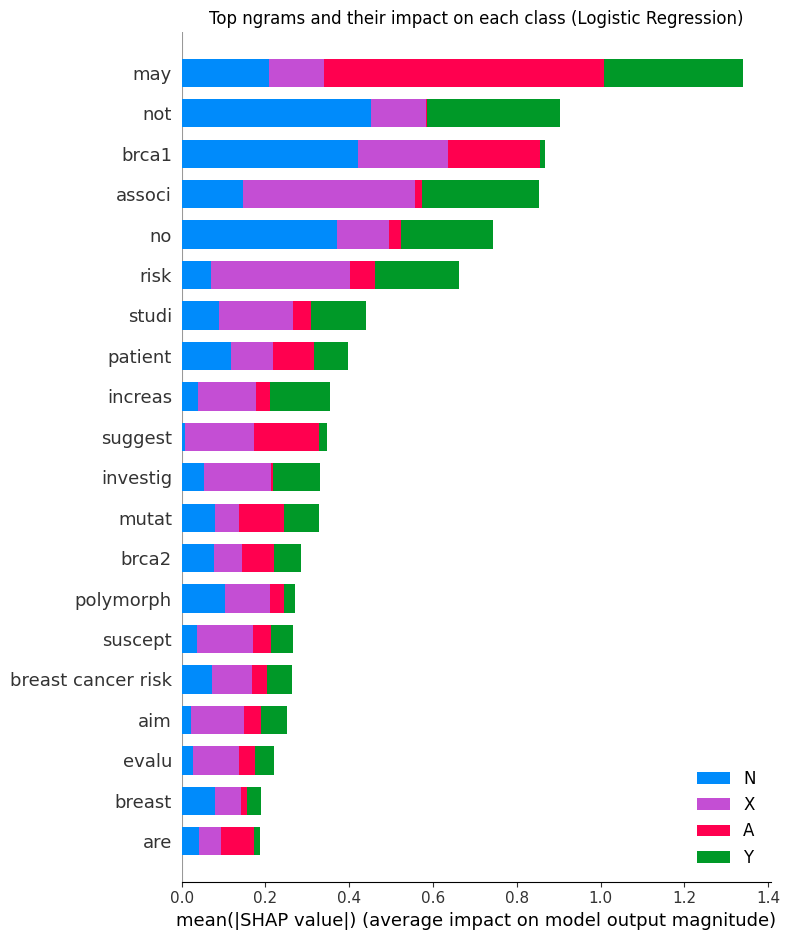

In [ ]:
feats = best_model['vectorizer'].get_feature_names_out()
vectorized_df = pd.DataFrame(test_sample.toarray(), columns = feats)
plt.title('Top ngrams and their impact on each class (Logistic Regression)')
shap.summary_plot(shap_values, vectorized_df, class_names=['A', 'N', 'X', 'Y'], class_inds=[1, 2, 0, 3], feature_names=feats)

,ngram,coefficient
38026,confirm,0.807523
10929,are associ,0.750579
155331,were associ,0.746935
80352,is associ,0.715063
75983,increas,0.675061
58505,found associ,0.568959
3484,account,0.556412
132208,signific associ,0.543367
73940,igfbp2,0.539074
68281,have associ,0.533501


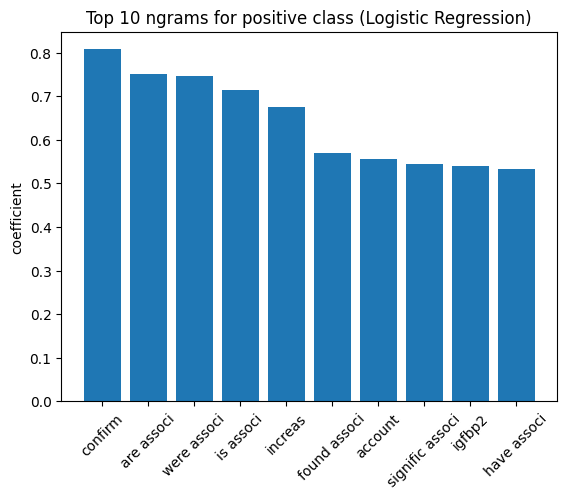

In [ ]:
# Top 20 tokens for positive class
positive_tokens = pd.DataFrame(data={'ngram': best_model['vectorizer'].get_feature_names_out(), 'coefficient': best_model['classifier'].coef_[3]})
positive_tokens = positive_tokens.sort_values('coefficient', ascending=False)
display(positive_tokens.head(10))
plt.bar(positive_tokens['ngram'].head(10), positive_tokens['coefficient'].head(10))
plt.xticks(rotation=45)
plt.ylabel('coefficient')
plt.title('Top 10 ngrams for positive class (Logistic Regression)')
plt.show()

,ngram,coefficient
96040,no,2.758349
97199,not,2.113314
97266,not associ,1.163914
96642,none,1.024996
96048,no associ,0.884167
47618,do,0.798474
47619,do not,0.798474
95474,neither,0.728574
156008,were not,0.648291
80935,is not,0.615877


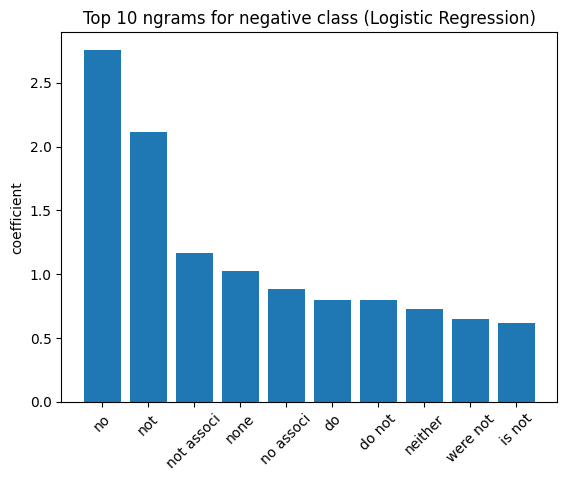

In [ ]:
# Top 20 tokens for negative class
negative_tokens = pd.DataFrame(data={'ngram': best_model['vectorizer'].get_feature_names_out(), 'coefficient': best_model['classifier'].coef_[1]})
negative_tokens = negative_tokens.sort_values('coefficient', ascending=False)
display(negative_tokens.head(10))
plt.bar(negative_tokens['ngram'].head(10), negative_tokens['coefficient'].head(10))
plt.xticks(rotation=45)
plt.ylabel('coefficient')
plt.title('Top 10 ngrams for negative class (Logistic Regression)')
plt.show()

,ngram,coefficient
87331,may,2.948259
89963,might,1.739982
40307,could,1.033516
108235,polymorph may,0.829625
95196,need,0.664840
18500,brca12,0.653016
139441,suggest,0.605455
87392,may associ,0.578585
87768,may not,0.550100
38922,contribut,0.544193


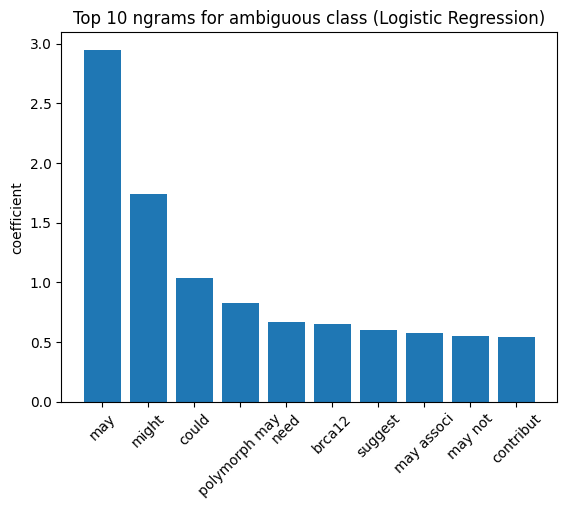

In [ ]:
# Top 20 tokens for ambiguous class
ambiguous_tokens = pd.DataFrame(data={'ngram': best_model['vectorizer'].get_feature_names_out(), 'coefficient': best_model['classifier'].coef_[0]})
ambiguous_tokens = ambiguous_tokens.sort_values('coefficient', ascending=False)
display(ambiguous_tokens.head(10))
plt.bar(ambiguous_tokens['ngram'].head(10), ambiguous_tokens['coefficient'].head(10))
plt.xticks(rotation=45)
plt.ylabel('coefficient')
plt.title('Top 10 ngrams for ambiguous class (Logistic Regression)')
plt.show()

,ngram,coefficient
79414,investig,1.295280
5903,aim,1.011710
156556,whether,0.817374
50802,er,0.788515
52543,evalu,0.785600
52563,evalu associ,0.737100
53459,examin,0.722366
12382,assess,0.704017
138728,studi wa,0.686038
54547,express,0.635629


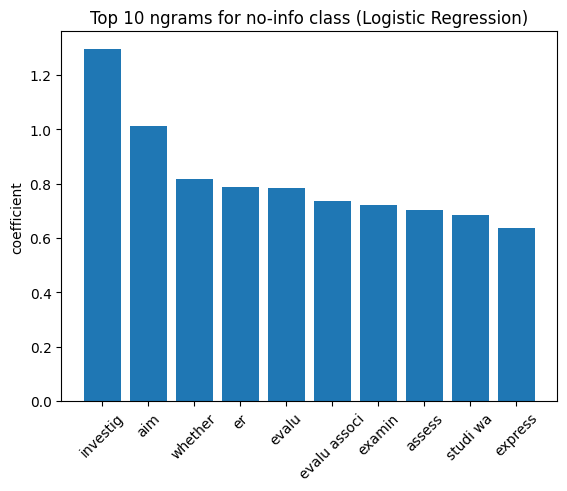

In [ ]:
# Top 20 tokens for no-information class
noinfo_tokens = pd.DataFrame(data={'ngram': best_model['vectorizer'].get_feature_names_out(), 'coefficient': best_model['classifier'].coef_[2]})
noinfo_tokens = noinfo_tokens.sort_values('coefficient', ascending=False)
display(noinfo_tokens.head(10))
plt.bar(noinfo_tokens['ngram'].head(10), noinfo_tokens['coefficient'].head(10))
plt.xticks(rotation=45)
plt.ylabel('coefficient')
plt.title('Top 10 ngrams for no-info class (Logistic Regression)')
plt.show()

### Predicting on sentences that mention genes with multiple associations

In [ ]:
# Sentences that mention multiple kinds of gene associations
multiple_associations = data.groupby(['REF_SENTENCE'])['ASSOCIATION_CLASS'].nunique().gt(1)
X_test_multiple_association = X_test.loc[X_test['REF_SENTENCE'].isin(multiple_associations[multiple_associations].index)]
y_test_multiple_association = y_test[y_test.index.isin(X_test.loc[X_test['REF_SENTENCE'].isin(multiple_associations[multiple_associations].index)].index)]
combined_multiple = pd.concat([X_test_multiple_association, y_test_multiple_association], axis=1)
combined_multiple[['REF_SENTENCE', 'ASSOCIATION_CLASS', 'prediction', 'REF_GENE']].sort_values(by=['REF_SENTENCE'])

,REF_SENTENCE,ASSOCIATION_CLASS,prediction,REF_GENE
837,A case (n=250)-control (n=500) study was under...,Y,A,TGFbeta1
833,A case (n=250)-control (n=500) study was under...,A,A,GSTP1
1672,"A cohort of 1,665 adult, female mutation carri...",N,N,IRS1
7802,A matched pairs study was carried out to ascer...,X,X,leptin
7890,"After exclusion of BRCA1, BRCA2, and syndromic...",X,Y,BARD1
...,...,...,...,...
2737,While BRCA1 and BRCA2 have taken center stage ...,X,Y,BRCA1
3094,With the known interaction of BRCA1 and IGF si...,A,A,AKT
9223,Younger age at first breast cancer diagnosis w...,Y,X,BRCA1
211,the results from our study suggest that the Ah...,N,A,CYP1A2*1F


In [ ]:
combined_multiple[combined_multiple['ASSOCIATION_CLASS'] != combined_multiple['prediction']][['REF_SENTENCE', 'ASSOCIATION_CLASS', 'prediction', 'REF_GENE']].sort_values(by=['REF_SENTENCE'])

,REF_SENTENCE,ASSOCIATION_CLASS,prediction,REF_GENE
837,A case (n=250)-control (n=500) study was under...,Y,A,TGFbeta1
7890,"After exclusion of BRCA1, BRCA2, and syndromic...",X,Y,BARD1
12,Although polymorphisms within the IL1 gene clu...,Y,N,IL6
6196,"Conclusively, our findings suggest that GSTT1 ...",Y,X,GSTT1
5298,Consistent with their breast cancer associatio...,N,Y,RAD51L1
...,...,...,...,...
9745,We found that the risk of breast cancer was as...,N,Y,PPARA
8301,When all the eligible studies were pooled into...,X,N,CI
2737,While BRCA1 and BRCA2 have taken center stage ...,X,Y,BRCA1
9223,Younger age at first breast cancer diagnosis w...,Y,X,BRCA1


In [ ]:
data.loc[9223]['REF_SENTENCE']

'Younger age at first breast cancer diagnosis was significantly associated with an increased 10-year risk of CBC for BRCA1 carriers (���������������������40 years vs. >40 years: 21.5% vs. 11.9%, unadjusted hazard ratio [HR] = 2.51, 95% CI, 1.03-6.15, p = 0.044), but not for BRCA2 carriers and noncarriers.'

In [ ]:
data[data['REF_SENTENCE'] == data.loc[9223]['REF_SENTENCE']]

,DB_ID,DISEASE,DIS_CLASS,GENE,PUBMED.ID,LACKASSO,TITLE,YEAR,CONCLUSION,REF_SENTENCE,ASSOCIATION_CLASS,REF_GENE,GENE_NEW,WEIGHT,REF_SENTENCE_GENE,REF_SENTENCE_GENE_nopunct,REF_SENTENCE_GENE_nopunct_nonum,REF_SENTENCE_GENE_nopunct_nonum_lower,REF_SENTENCE_GENE_nopunct_nonum_lower_nostop,REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem
9223,DBN_6079,breast cancer,CANCER,BRCA1,32037537,NOT REPORTED,NaN,2020,NOT REPORTED,Younger age at first breast cancer diagnosis w...,Y,BRCA1,BRCA1,0.484536,Younger age at first breast cancer diagnosis w...,Younger age at first breast cancer diagnosis w...,Younger age at first breast cancer diagnosis w...,younger age at first breast cancer diagnosis w...,younger age first breast cancer diagnosis was ...,younger age first breast cancer diagnosi wa si...
9228,DBN_6083,breast cancer,CANCER,BRCA2,32037537,NOT REPORTED,NaN,2020,NOT REPORTED,Younger age at first breast cancer diagnosis w...,X,BRCA2,X,0.000000,Younger age at first breast cancer diagnosis w...,Younger age at first breast cancer diagnosis w...,Younger age at first breast cancer diagnosis w...,younger age at first breast cancer diagnosis w...,younger age first breast cancer diagnosis was ...,younger age first breast cancer diagnosi wa si...
